In [23]:
import os
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import numpy as np
import pandas as pd

In [24]:
class ProstateCancerDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_map = {"gland": 0, "nongland": 1, "tumor": 2}  # Map folder names to labels

        for label_name, label_id in self.label_map.items():
            folder_path = os.path.join(self.root_dir, label_name)
            for file_name in os.listdir(folder_path):
                if file_name.endswith((".jpg", ".png")):  # Ensure we only load image files
                    self.image_paths.append(os.path.join(folder_path, file_name))
                    self.labels.append(label_id)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = PIL.Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        return self.transform(image), label

In [ ]:
dataset_path = "Datasets/Prostate Cancer/"  

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
def train_test_split(dataset, test_ratio=0.2):
    indices = np.arange(len(dataset))
    np.random.shuffle(indices)
    split = int(len(dataset) * (1 - test_ratio))
    train_indices, test_indices = indices[:split], indices[split:]
    return torch.utils.data.Subset(dataset, train_indices), torch.utils.data.Subset(dataset, test_indices)

full_dataset = ProstateCancerDataset(dataset_path, transform)
train_dataset, test_dataset = train_test_split(full_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize Pre-trained ResNet**
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))  # Remove the final classification layer
resnet.eval()  

def extract_features(loader, model):
    features, labels = [], []
    with torch.no_grad():
        for images, lbls in loader:
            feats = model(images).squeeze(-1).squeeze(-1).numpy()  # Flatten features
            features.append(feats)
            labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

train_features, train_labels = extract_features(train_loader, resnet)
test_features, test_labels = extract_features(test_loader, resnet)

classifier = RandomForestClassifier()
classifier.fit(train_features, train_labels)


RandomForestClassifier()

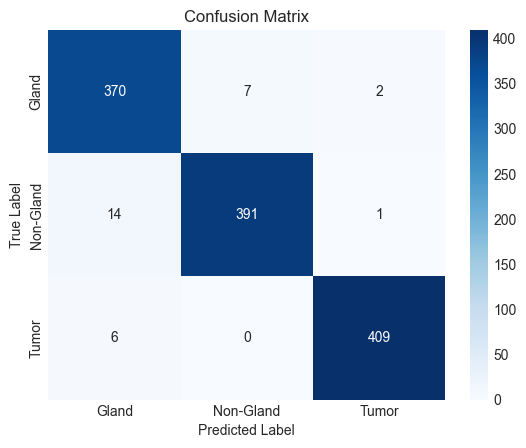

Classification Report:
              precision    recall  f1-score   support

       Gland       0.95      0.98      0.96       379
   Non-Gland       0.98      0.96      0.97       406
       Tumor       0.99      0.99      0.99       415

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.98      0.97      0.98      1200



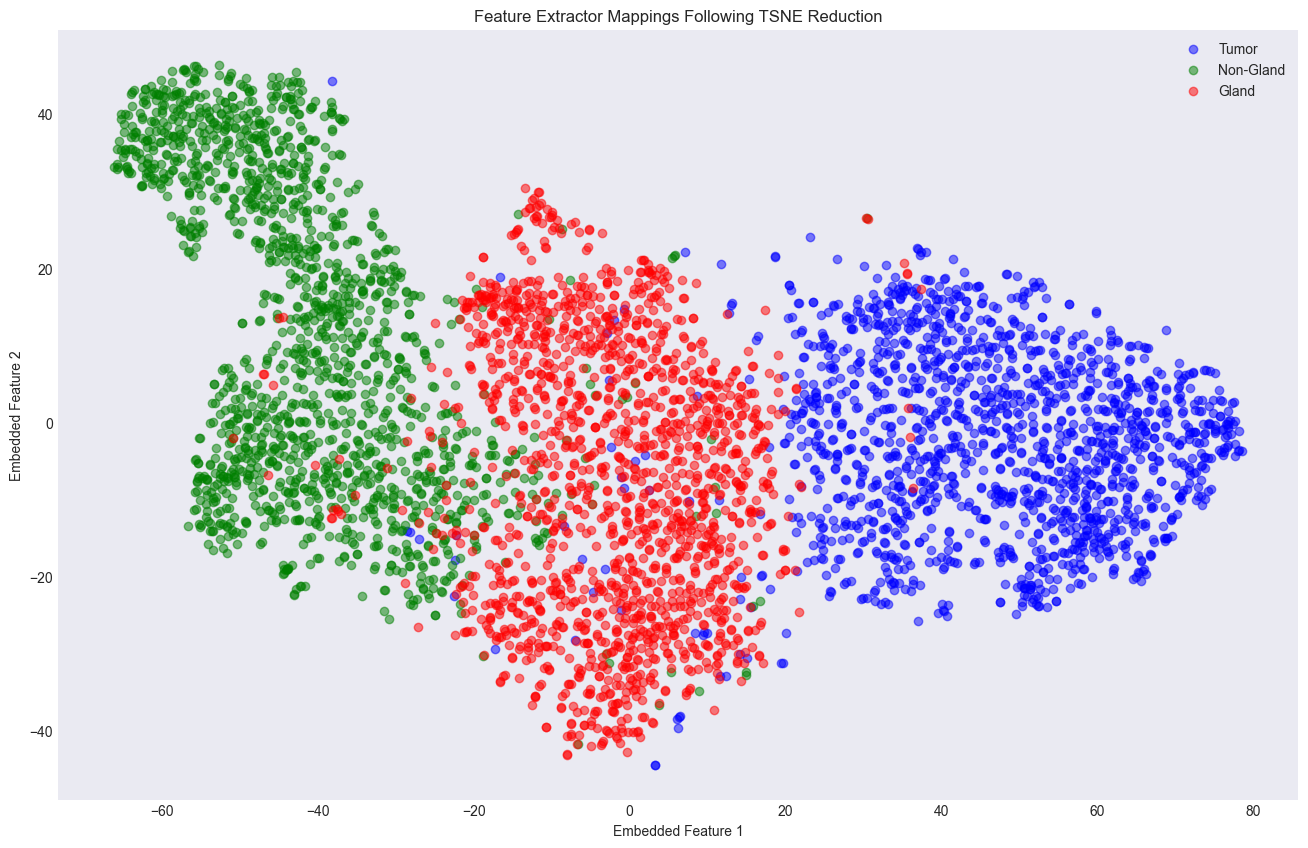

In [ ]:
predictions = classifier.predict(test_features)

cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Gland", "Non-Gland", "Tumor"], yticklabels=["Gland", "Non-Gland", "Tumor"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predictions, target_names=["Gland", "Non-Gland", "Tumor"]))

def create_embedding_dataframe(_full_train_feature_map_set, _full_train_label_set):
    reduction_fitter = TSNE(random_state=42)
    embeddings = reduction_fitter.fit_transform(_full_train_feature_map_set)
    embedding_dataframe = pd.DataFrame(embeddings, columns=["x_embedded", "y_embedded"])
    embedding_dataframe["label"] = _full_train_label_set
    return embedding_dataframe

def plot_tsne_embedding(_embedding_dataframe):
    colors = ["red", "green", "blue"]
    label_names = ["Gland", "Non-Gland", "Tumor"]

    plt.style.use('seaborn-v0_8-dark')
    fig, ax = plt.subplots(figsize=(16, 10))
    for i in _embedding_dataframe["label"].unique():
        label_embedding_values = _embedding_dataframe[_embedding_dataframe.label == i]
        ax.scatter(label_embedding_values.x_embedded, label_embedding_values.y_embedded, 
                   label=label_names[i], c=colors[i], alpha=0.5)

    ax.set_xlabel("Embedded Feature 1")
    ax.set_ylabel("Embedded Feature 2")
    ax.set_title("Feature Extractor Mappings Following TSNE Reduction")
    ax.legend()
    plt.show()

embedding_df = create_embedding_dataframe(train_features, train_labels)
plot_tsne_embedding(embedding_df)